In [1]:
import tensorflow as tf
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense, Activation, Dropout
from keras import regularizers
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

%matplotlib inline
np.random.seed(20181111)

Using TensorFlow backend.


In [2]:
data = np.loadtxt('Control_Debris_1.csv', delimiter=',', skiprows=1)

In [ ]:
num_training=40
models = []
histories = []

def load_data():
    data = np.loadtxt('Control_Debris_1.csv', delimiter=',', skiprows=1)
    
    #mean = np.mean(data, axis=0, keepdims=True)
    #delta = data - mean
    #std = np.sqrt(np.mean(delta**2, axis=0, keepdims=True))
    #data = delta / std
    
    #data_max = np.max(data, axis=0, keepdims=True)
    #data = data / data_max 
    
    np.random.shuffle(data) 
    
    X = data[:, 1:]
    y = data[:, 0]

    return X, y

X, y = load_data();
X, y = load_data();

print('Dataset: ', X.shape)

X_train = X[:num_training, :]
y_train = y[:num_training]

X_test = X[num_training:, :]
y_test = y[num_training:]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Dataset:  (60, 38)
X_train shape: (40, 38)
y_train shape: (40,)
X_test shape: (20, 38)
y_test shape: (20,)


In [ ]:
activation='relu'

def regularizer():
    return keras.regularizers.l2(0.0005)

dropout = 0.15
node_count = 38
#model
def build_mode():
    model = keras.models.Sequential([
        Dense(node_count, activation=activation, kernel_initializer='normal', kernel_regularizer=regularizer()),
        Dropout(dropout),
        Dense(int(node_count / 2), activation=activation, kernel_initializer='normal', kernel_regularizer=regularizer()),
        Dropout(dropout),
        Dense(int(node_count / 4), activation='sigmoid', kernel_initializer='normal', kernel_regularizer=regularizer()),
        Dropout(dropout),
        Dense(1)])


    def loss(y_true, y_pred):
        SS_res =  K.sum(K.square(y_true - y_pred)) 
        y_mean = K.mean(y_true)
        SS_reg = K.sum(K.square(y_pred - y_mean))
        SS_tot = SS_res + SS_reg
        print(K.int_shape(y_pred))
        return K.abs(SS_res/(SS_tot))
# getting r2
    def r2(y_true, y_pred):
        return 1.0 - loss(y_true, y_pred)

    
    model.compile(optimizer=keras.optimizers.Adam(lr=0.0001),
                  loss=loss,
                  metrics=[r2, 'mse', 'mae', 'mape', 'cosine'])
    models.append(model)
    return model

wrapped_model = KerasRegressor(build_fn=build_mode)
#fit the model
history = wrapped_model.fit(X_train, y_train,batch_size=20, epochs=2000, verbose=0, validation_split=0.1)
#conducting permutation 
perm = PermutationImportance(wrapped_model).fit(X_test, y_test)

model = models[-1]
histories.append(history)


(None, 1)
(None, 1)


In [ ]:
eli5.show_weights(perm, top=None)


In [5]:
score_test = model.evaluate(X_test, y_test)
print("Test====")
print(model.metrics_names)
print(score_test)

20/20 [==============================] - 0s 158us/step
Test====
['loss', 'r2', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity']
[0.6850113868713379, 0.3190124034881592, 0.0017918571829795837, 0.029649198055267334, 58.160438537597656, -1.0]


In [6]:
score_train = model.evaluate(X_train, y_train)
print("Train====")
print(model.metrics_names)
print(score_train)

40/40 [==============================] - 0s 168us/step
Train====
['loss', 'r2', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity']
[0.31536661386489867, 0.6886572003364563, 0.0009216151898726821, 0.02359514907002449, 37.458255767822266, -0.95]


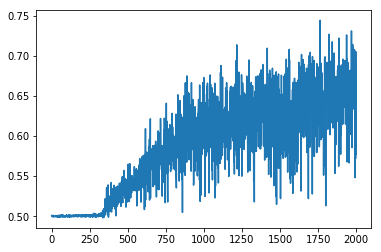

In [7]:
plot_begin = 0
history.history['r2'][plot_begin:]
plt.plot(history.history['r2'][plot_begin:])
#plt.plot(history.history['r2'][plot_begin:], label="Train")

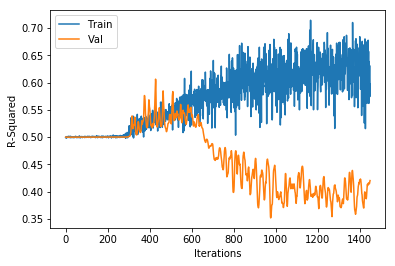

In [6]:
plot_begin = 50
# plot metrics

plt.plot(history.history['r2'][plot_begin:1500], label="Train")
plt.plot(history.history['val_r2'][plot_begin:1500], label="Val")
plt.ylabel('R-Squared')
plt.xlabel('Iterations')
plt.legend()
plt.show()

20/20 [==============================] - 0s 143us/step
Test====
['loss', 'r2', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity']
[0.5986971259117126, 0.4059191942214966, 0.011402188800275326, 0.06210324168205261, 133.72061157226562, -0.8999999761581421]
40/40 [==============================] - 0s 206us/step
Train====
['loss', 'r2', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity']
[0.19685706496238708, 0.8077592492103577, 0.001120322966016829, 0.023695531114935876, 53.114437866210935, -0.95]


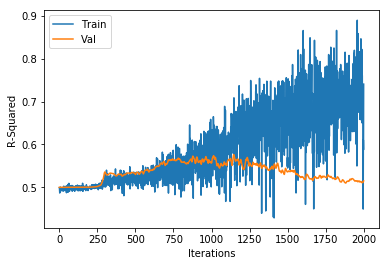

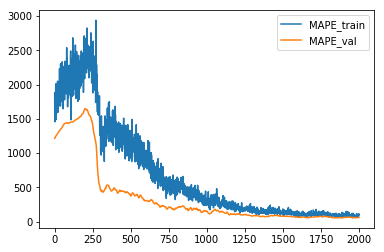

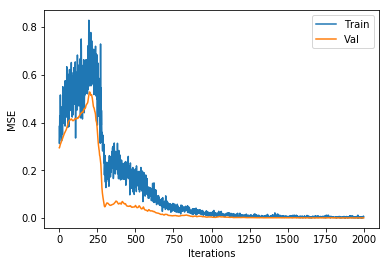

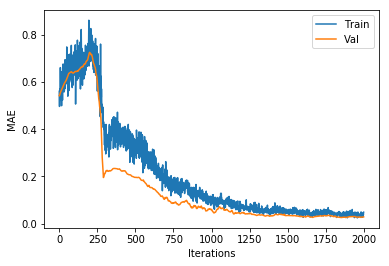

In [122]:
score_test = model.evaluate(X_test, y_test)
print("Test====")
print(model.metrics_names)
print(score_test)


score_train = model.evaluate(X_train, y_train)
print("Train====")
print(model.metrics_names)
print(score_train)

plot_begin = 0
# plot metrics

plt.plot(history.history['r2'][plot_begin:], label="Train")
plt.plot(history.history['val_r2'][plot_begin:], label="Val")
plt.ylabel('R-Squared')
plt.xlabel('Iterations')
plt.legend()
plt.show()

plt.plot(history.history['mean_absolute_percentage_error'][plot_begin:], label="MAPE_train")
plt.plot(history.history['val_mean_absolute_percentage_error'][plot_begin:], label="MAPE_val")
plt.legend()
plt.show()

plt.plot(history.history['mean_squared_error'][plot_begin:], label="Train")
plt.plot(history.history['val_mean_squared_error'][plot_begin:], label="Val")
plt.ylabel('MSE')
plt.xlabel('Iterations')
plt.legend()
plt.show()

plt.plot(history.history['mean_absolute_error'][plot_begin:], label="Train")
plt.plot(history.history['val_mean_absolute_error'][plot_begin:], label="Val")
plt.ylabel('MAE')
plt.xlabel('Iterations')
plt.legend()
plt.show()

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 38)                1482      
_________________________________________________________________
dropout_22 (Dropout)         (None, 38)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 19)                741       
_________________________________________________________________
dropout_23 (Dropout)         (None, 19)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 9)                 180       
_________________________________________________________________
dropout_24 (Dropout)         (None, 9)                 0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 10        
Total para

In [48]:
data = np.loadtxt('Total.csv', delimiter=',', skiprows=1)
results = np.zeros_like(data)
features = data[:, 1:]

for i in range(features.shape[1]):
    input_data = np.array(features, copy=True)
    input_data[:, i] *= 1.05
    a = model.predict(input_data)
    input_data = np.array(features, copy=True)
    input_data[:, i] *= 0.95
    b = model.predict(input_data)
    
    results[:, i] = np.reshape((a - b) / b, (-1))

results[:, 0] = data[:, 0]

header = None
with open('Total.csv', 'r') as f:
    header = f.readline().replace('\n', '')

np.savetxt('sensitivity_analysis.csv', results, fmt='%.8f', delimiter=',', header=header, comments='')

In [49]:
history.history['val_r2'][1999]

0.29265081882476807

In [50]:
y_pred = model.predict(X_test, batch_size=180)

In [51]:
y_pred

array([[0.0708125 ],
       [0.12450178],
       [0.212217  ],
       [0.28499222],
       [0.06254758],
       [0.10114898],
       [0.15920505],
       [0.07513876],
       [0.12691273],
       [0.05683928],
       [0.1445638 ],
       [0.11220785],
       [0.09468781],
       [0.05789661],
       [0.08248702],
       [0.05033377],
       [0.07393241],
       [0.11924925],
       [0.08194876],
       [0.7742812 ],
       [0.12562487],
       [0.08750586],
       [0.13686296],
       [0.12703231],
       [0.08996429],
       [0.06676766],
       [0.07548618],
       [0.08495192],
       [0.08109958],
       [0.07712973],
       [0.06559174],
       [0.08219907],
       [0.08527898],
       [0.07799425],
       [0.12909552],
       [0.09314417],
       [0.11165825],
       [0.1057101 ],
       [0.06509842],
       [0.06442446],
       [0.08014239],
       [0.07095455],
       [0.08300498],
       [0.07552637],
       [0.20506871],
       [0.05918689],
       [0.08701247],
       [0.534

In [775]:
y_test

array([0.012     , 0.03571429, 0.276     , 0.56      , 0.179     ,
       0.0175    , 0.15857143, 0.03833333, 0.02857143, 0.02      ,
       0.04714286, 0.08142857, 0.01666667, 0.01      , 0.08571429,
       0.045     , 0.095     , 0.052     , 0.148     , 1.76444444,
       0.065     , 0.05      , 0.05      , 0.0525    , 0.1       ,
       0.064     , 0.01333333, 0.05571429, 0.02875   , 0.074     ,
       0.02      , 0.078     , 0.03125   , 0.015     , 0.03      ,
       0.095     , 1.73222222, 0.016     , 0.0525    , 0.015     ,
       0.03857143, 0.02375   , 0.02      , 0.0425    , 0.04      ,
       0.03      , 0.078     , 0.658125  , 0.03428571, 0.42571429,
       0.0325    , 0.044     , 0.103375  , 0.015     , 0.415     ,
       0.18166667, 1.15      , 0.121     , 0.04428571, 0.215     ])

In [776]:
np.savetxt("4.csv", y_pred, delimiter=",")

In [777]:
np.savetxt("5.csv", y_test, delimiter=",")

In [778]:
data1 = np.loadtxt('4.csv',delimiter=',',skiprows=0) 

In [780]:
data2 = np.loadtxt('5.csv',delimiter=',',skiprows=0) 

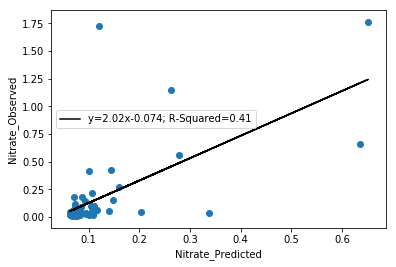

In [832]:
fit=np.polyfit(data1,data2,1)
fit_fn = np.poly1d(fit) 
plt.plot(data1, fit_fn(data1), '-k',label='y=2.02x-0.074; R-Squared=0.41')
plt.ylabel('Nitrate_Observed')
plt.xlabel('Nitrate_Predicted')
plt.legend()
plt.scatter(data1, data2)
plt.show()
